# 📊 [TRAIN]My_Simple_Baseline

## 🎯 目的
データの前処理 -> 学習・推論 -> アウトプット -> 可視化分析まで実行

## 🔄 25.12.26: 主な改良点
1. **Config の統合**: すべての設定を一元管理
2. **Preprocessor の改善**: Config ベースで制御、密行列統合
3. **モデル学習の改善**: 正しい目的変数、LabelEncoding、OOF保存
4. **可視化・分析**: 分布比較、Feature Importance、Confusion Matrix

---

In [1]:
# ======================
# 📦 Import libraries
# ======================
import os, gc, re, yaml, glob, pickle, warnings
import time
import random, math
import joblib, itertools
from pathlib import Path

import numpy as np
import scipy as sp
import polars as pl
import pandas as pd
from tqdm.auto import tqdm
from typing import Union, Any, Dict, Optional, List, Tuple
from types import SimpleNamespace

# 化学系ライブラリ
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, Crippen
from rdkit.Chem import rdFingerprintGenerator

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_fontja

# Cross validation
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

# Model
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve, 
    root_mean_squared_error, mean_squared_error,
    confusion_matrix, classification_report
)
from scipy.stats import spearmanr

# W&B
import wandb
from kaggle_secrets import UserSecretsClient

from datetime import datetime
date = datetime.now().strftime("%Y%m%d")
print(f"✅ TODAY is {date}")

warnings.filterwarnings('ignore')

# 🎨 Pandas表示設定
# カラム数の表示制限を解除
pd.set_option('display.max_columns', None)  # 全カラム表示
pd.set_option('display.max_rows', 100)      # 最大100行表示
# pd.set_option('display.width', None)        # 幅制限なし
# pd.set_option('display.max_colwidth', 50)   # カラム内の文字数制限
# 数値の表示形式
pd.set_option('display.precision', 3)       # 小数点以下4桁
pd.set_option('display.float_format', '{:.3f}'.format)  # float表示形式
print("✅ Pandas display options configured")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, an

✅ TODAY is 20251228
✅ Pandas display options configured


In [2]:
# ==========================
# 🔧 W&B Setup
# ==========================
os.environ["WANDB_ENTITY"] = "hidebu"
os.environ["WANDB_PROJECT"] = "DSOW2025-improved-baseline"
os.environ["WANDB_BASE_URL"] = "https://toyota.wandb.io"

secret_label = "wandb_tmc_key"
os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret(secret_label)

BASE_GROUP = os.environ.get("WANDB_BASE_GROUP", "")
if not BASE_GROUP:
    BASE_GROUP = f"lc-improved-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    os.environ["WANDB_BASE_GROUP"] = BASE_GROUP

print("✅ W&B Entity:", os.environ.get("WANDB_ENTITY"))
print("✅ W&B Project:", os.environ.get("WANDB_PROJECT"))
print("✅ Base Group:", BASE_GROUP)

✅ W&B Entity: hidebu
✅ W&B Project: DSOW2025-improved-baseline
✅ Base Group: lc-improved-20251228-044833


In [3]:
# ============================================================
# 🎛️ 設定クラス
# ============================================================
class Config:
    """全ての設定を一元管理するクラス"""
    
    def __init__(self):
        # === 基本設定 ===
        self.seed = 42
        self.n_splits = 5
        self.data_dir = Path("/kaggle/input/data-science-osaka-winter-2025")
        self.output_dir = Path("/kaggle/working")
        self.output_dir.mkdir(exist_ok=True, parents=True)
        
        # ターゲット変数
        self.cls_target = "is_thermotropic_lc"      # 分類: 液晶かどうか
        self.reg_target = "clearing_point_celsius"  # 回帰: 透明点の温度
        
        # === 前処理設定 ===
        self.preprocessor = SimpleNamespace(
            verbose=True,
            n_bits=1_024,                   # ECFP4のビット数
            radius=4,                       # ECFP4の半径
            tfidf_ngram_range=(1, 4),       # TF-IDFのn-gram範囲
            tfidf_min_df=2,                 # 最小出現回数
            tfidf_max_features=10_000,      # TF-IDFの最大特徴量数
            include_molecular=True,         # 分子記述子を含める
            include_name=True,              # 化合物名特徴量を含める
            include_phase=True,             # 相転移特徴量を含める
            include_ecfp4=True,             # ECFP4を含める
            include_tfidf=True,             # TF-IDFを含める
            use_svd=True,                   # SVDを使用するか
            ecfp4_n_components=128,          # ECFP4のSVD次元数
            tfidf_n_components=32,          # TF-IDFのSVD次元数
        )
        
        # === モデル設定 ===
        self.model = SimpleNamespace(
            # 分類タスク
            classification=dict(
                objective="binary",
                metric=["binary_logloss"],
                learning_rate=0.01,
                num_leaves=255,
                min_data_in_leaf=100,
                feature_fraction=0.6,
                bagging_fraction=0.6,
                bagging_freq=1,
                lambda_l1=0.0,
                lambda_l2=0.1,
                seed=42,
                verbosity=-1,
                # colsample_bytree=1,
                # min_child_samples=50,
                # reg_lambda=10,
                # reg_alpha=0,
                # subsample=0.8,
                num_boost_round=5_000,
                early_stopping_rounds=500,
            ),
            # 回帰タスク
            regression=dict(
                objective="regression",
                metric=["mse"],
                learning_rate=0.003,
                num_leaves=63,
                min_data_in_leaf=10,
                feature_fraction=0.6,
                bagging_fraction=1.0,
                bagging_freq=3,
                lambda_l1=1.0,
                lambda_l2=1.0,
                seed=42,
                verbosity=-1,
                # min_child_samples=10,
                # colsample_bytre=0.9,
                num_boost_round=5_000,
                # reg_alpha=0,
                # reg_lambda=0,
                # subsample=0.6,
                early_stopping_rounds=500,
            )
        )
        
        # === W&B設定 ===
        self.wandb = SimpleNamespace(
            use_wandb=True,
            entity=os.environ.get("WANDB_ENTITY"),
            project=os.environ.get("WANDB_PROJECT"),
            base_group=os.environ.get("WANDB_BASE_GROUP"),
        )
        
        # === 可視化設定 ===
        self.viz = SimpleNamespace(
            figsize=(15, 5),
            dpi=100,
            top_n_features=30,
        )

config = Config()
print(f"✅ Config initialized: seed={config.seed}, n_splits={config.n_splits}")

✅ Config initialized: seed=42, n_splits=5


In [4]:
# ========== 🛠️ Utils ==========
def sep(word: str, num: int = 80):
    """セパレータ付きメッセージ表示"""
    print("=" * num)
    print(f"✨ {word}")
    print("=" * num)

def show_df(df: Union[pd.DataFrame, pl.DataFrame], num: int = 3, show_tail: bool = False):
    """DataFrameの概要表示"""
    print(f"📊 Shape: {df.shape}")
    display(df.head(num))
    if show_tail:
        display(df.tail(num))

def seed_everything(seed=42):
    """シード固定"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed=config.seed)
print(f"✅ Seed fixed: {config.seed}")

✅ Seed fixed: 42


---
# 1️⃣ データ読み込み

In [5]:
sep("📂 データ読み込み")

train_df = pl.read_csv(config.data_dir / "train.csv")
test_df = pl.read_csv(config.data_dir / "test.csv")

print(f"📊 Train: {train_df.shape}")
print(f"📊 Test: {test_df.shape}")

# Train/Test フラグを追加
train_df = train_df.with_columns(pl.lit(True).alias("is_train"))
test_df = test_df.with_columns(pl.lit(False).alias("is_train"))

# 結合
df = pl.concat([train_df, test_df], how="diagonal")
sep("結合後のデータ"); show_df(df)

✨ 📂 データ読み込み
📊 Train: (1020, 11)
📊 Test: (1127, 6)
✨ 結合後のデータ
📊 Shape: (2147, 12)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius,is_train
i64,str,str,str,str,str,str,str,bool,i64,f64,bool
0,"""4-[(4-nitrophenoxy)carbonyl]ph…","""CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(…","""Monotropic""","""Cr 147 I (N 97 I) (NF 85 N)""","""A tri-aryl ester comprising a …","""New_Gemini""","""paper_0437""",true,0,97.0,true
1,"""Poly[oxy(2,4,4,6,6,8,10,10,12,…","""*O[Si]1(C)O[Si](C)(C)C[Si](C)(…","""Thermotropic""","""M 240 I""","""A cyclolinear polyorganocarbos…","""New_Gemini""","""paper_0005""",true,1,240.0,true
2,"""2,5,9-Tris(3,4-dihexyloxypheny…","""CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3…","""Thermotropic""","""Cr 100 M 225 I""","""A star-shaped heteroaromatic s…","""New_Gemini""","""paper_0034""",true,1,225.0,true


---
# 2️⃣ 前処理（改良版）

In [6]:
# ============================================================
# 🔧 前処理クラス（完全版 - SVD対応）
# ============================================================
"""
液晶予測のための特徴量抽出クラス

処理の流れ:
1. null値の補完
2. 分子記述子の抽出（SMILESから）
3. 化合物名の特徴量
4. 相転移挙動の特徴量
5. ECFP4（分子フィンガープリント）→ SVDで次元削減
6. TF-IDF（テキスト特徴量）→ SVDで次元削減

SVD機能:
- ECFP4: 2048次元 → 64次元（設定可能）
- TF-IDF: 2000次元 → 64次元（設定可能）
- メモリ使用量を大幅に削減（約96%削減）
"""

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer


class LiquidCrystalPreprocessor:
    """液晶予測のための特徴量抽出クラス（SVD対応完全版）"""
    
    def __init__(self, config: Config):
        self.cfg = config.preprocessor
        self.verbose = self.cfg.verbose
        
        # TF-IDF Vectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            ngram_range=self.cfg.tfidf_ngram_range,
            min_df=self.cfg.tfidf_min_df,
            max_features=self.cfg.tfidf_max_features,
        ) if self.cfg.include_tfidf else None
        
        # ECFP4用SVD（use_svd=Trueの場合のみ初期化）
        self.ecfp4_svd = TruncatedSVD(
            n_components=self.cfg.ecfp4_n_components,
            random_state=config.seed
        ) if (self.cfg.use_svd and self.cfg.include_ecfp4) else None
        
        # TF-IDF用SVD（use_svd=Trueの場合のみ初期化）
        self.tfidf_svd = TruncatedSVD(
            n_components=self.cfg.tfidf_n_components,
            random_state=config.seed
        ) if (self.cfg.use_svd and self.cfg.include_tfidf) else None
        
        # null値補完戦略
        self._null_filling = {
            'lc_type': 'Unknown',
            'phase_transition_behavior': '',
            'smiles_source': 'Unknown',
            'description': '',
        }
        
        if self.verbose:
            print("✅ Preprocessor initialized")
            print(f"   ECFP4: {self.cfg.n_bits} bits, radius={self.cfg.radius}")
            if self.cfg.use_svd and self.cfg.include_ecfp4:
                print(f"   ECFP4 SVD: {self.cfg.n_bits} → {self.cfg.ecfp4_n_components} dims")
            print(f"   TF-IDF: max_features={self.cfg.tfidf_max_features}")
            if self.cfg.use_svd and self.cfg.include_tfidf:
                print(f"   TF-IDF SVD: {self.cfg.tfidf_max_features} → {self.cfg.tfidf_n_components} dims")
    
    # ================================================
    # 🔧 null値処理
    # ================================================
    def handle_null_values(self, df: pl.DataFrame) -> pl.DataFrame:
        """null値を適切に処理"""
        if self.verbose:
            sep("🔧 null値の処理")
        
        df_filled = df.clone()
        
        for col, fill_value in self._null_filling.items():
            if col in df_filled.columns:
                null_count = df_filled[col].null_count()
                if null_count > 0:
                    if self.verbose:
                        print(f"🔄 {col}: {null_count}個のnullを '{fill_value}' で補完")
                    df_filled = df_filled.with_columns(
                        pl.col(col).fill_null(fill_value)
                    )
        
        if self.verbose:
            print("✅ null値の処理完了")
        
        return df_filled
    
    # ================================================
    # 🧪 分子特徴量
    # ================================================
    @staticmethod
    def _extract_molecular_descriptors(smiles: str) -> Dict[str, Any]:
        """SMILESから分子記述子を抽出"""
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is None:
            # 無効なSMILESの場合はNaN/Falseで埋める
            return {
                'mol_weight': np.nan,
                'mol_num_atoms': np.nan,
                'mol_num_heavy_atoms': np.nan,
                'mol_num_carbons': np.nan,
                'mol_num_nitrogens': np.nan,
                'mol_num_oxygens': np.nan,
                'mol_num_aromatic_rings': np.nan,
                'mol_num_rings': np.nan,
                'mol_num_rotatable_bonds': np.nan,
                'mol_fraction_csp3': np.nan,
                'mol_num_h_acceptors': np.nan,
                'mol_num_h_donors': np.nan,
                'mol_logP': np.nan,
                'mol_tpsa': np.nan,
                'mol_has_cyano': False,
                'mol_has_biphenyl': False,
                'mol_has_ester': False,
            }
        
        # 各種分子記述子を計算
        features = {
            'mol_weight': Descriptors.MolWt(mol),
            'mol_num_atoms': mol.GetNumAtoms(),
            'mol_num_heavy_atoms': Descriptors.HeavyAtomCount(mol),
            'mol_num_carbons': sum(1 for a in mol.GetAtoms() if a.GetSymbol() == 'C'),
            'mol_num_nitrogens': sum(1 for a in mol.GetAtoms() if a.GetSymbol() == 'N'),
            'mol_num_oxygens': sum(1 for a in mol.GetAtoms() if a.GetSymbol() == 'O'),
            'mol_num_aromatic_rings': Descriptors.NumAromaticRings(mol),
            'mol_num_rings': Descriptors.RingCount(mol),
            'mol_num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
            'mol_fraction_csp3': Descriptors.FractionCSP3(mol),
            'mol_num_h_acceptors': Descriptors.NumHAcceptors(mol),
            'mol_num_h_donors': Descriptors.NumHDonors(mol),
            'mol_logP': Crippen.MolLogP(mol),
            'mol_tpsa': Descriptors.TPSA(mol),
            'mol_has_cyano': mol.HasSubstructMatch(Chem.MolFromSmarts('C#N')),
            'mol_has_biphenyl': mol.HasSubstructMatch(Chem.MolFromSmarts('c1ccc(cc1)c2ccccc2')),
            'mol_has_ester': mol.HasSubstructMatch(Chem.MolFromSmarts('C(=O)O')),
        }
        
        return features
    
    def add_molecular_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """分子特徴量を追加"""
        if not self.cfg.include_molecular:
            return df
        
        if self.verbose:
            sep("🧪 分子特徴量の抽出")
        
        df_pd = df.to_pandas()
        features_list = []
        
        iterator = tqdm(df_pd['smiles_guess'], desc="分子特徴量") if self.verbose else df_pd['smiles_guess']
        
        for smiles in iterator:
            features_list.append(self._extract_molecular_descriptors(smiles))
        
        features_df = pd.DataFrame(features_list)
        result_df = pd.concat([df_pd, features_df], axis=1)
        
        if self.verbose:
            print(f"✅ 抽出完了: {len(features_df.columns)}個の特徴量")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🏷️ 化合物名特徴量
    # ================================================
    @staticmethod
    def _extract_name_features(name: str) -> Dict[str, Any]:
        """化合物名から特徴量を抽出"""
        if not isinstance(name, str) or name is None or name == '':
            return {
                'name_length': 0,
                'name_num_digits': 0,
                'name_has_alkyl': False,
                'name_has_phenyl': False,
                'name_has_cyano': False,
            }
        
        name_lower = name.lower()
        
        features = {
            'name_length': len(name),
            'name_num_digits': len(re.findall(r'\d', name)),
            'name_has_alkyl': bool(re.search(r'alkyl', name_lower)),
            'name_has_phenyl': bool(re.search(r'phenyl', name_lower)),
            'name_has_cyano': bool(re.search(r'cyano', name_lower)),
        }
        
        return features
    
    def add_name_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """化合物名特徴量を追加"""
        if not self.cfg.include_name:
            return df
        
        if self.verbose:
            sep("🏷️ 化合物名特徴量の抽出")
        
        df_pd = df.to_pandas()
        features_list = []
        
        iterator = tqdm(df_pd['compound_name'], desc="化合物名特徴量") if self.verbose else df_pd['compound_name']
        
        for name in iterator:
            features_list.append(self._extract_name_features(name))
        
        features_df = pd.DataFrame(features_list)
        result_df = pd.concat([df_pd, features_df], axis=1)
        
        if self.verbose:
            print(f"✅ 抽出完了: {len(features_df.columns)}個の特徴量")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🌡️ 相転移特徴量
    # ================================================
    @staticmethod
    def _extract_phase_features(behavior: str) -> Dict[str, Any]:
        """相転移挙動から特徴量を抽出"""
        if not isinstance(behavior, str) or behavior is None or behavior == '':
            return {
                'phase_has_nematic': False,
                'phase_has_smectic': False,
                'phase_has_crystal': False,
                'phase_num_temperatures': 0,
                'phase_first_temp': np.nan,
                'phase_highest_temp': np.nan,
            }
        
        behavior_upper = behavior.upper()
        temperatures = [float(t) for t in re.findall(r'\d+\.?\d*', behavior)]
        
        features = {
            'phase_has_nematic': bool(re.search(r'\bN\b', behavior_upper)),
            'phase_has_smectic': bool(re.search(r'\bS[A-Z]?\b', behavior_upper)),
            'phase_has_crystal': bool(re.search(r'\bCR\b', behavior_upper)),
            'phase_num_temperatures': len(temperatures),
            'phase_first_temp': temperatures[0] if temperatures else np.nan,
            'phase_highest_temp': max(temperatures) if temperatures else np.nan,
        }
        
        return features
    
    def add_phase_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """相転移特徴量を追加"""
        if not self.cfg.include_phase or 'phase_transition_behavior' not in df.columns:
            return df
        
        if self.verbose:
            sep("🌡️ 相転移特徴量の抽出")
        
        df_pd = df.to_pandas()
        features_list = []
        
        iterator = tqdm(df_pd['phase_transition_behavior'], desc="相転移特徴量") if self.verbose else df_pd['phase_transition_behavior']
        
        for behavior in iterator:
            features_list.append(self._extract_phase_features(behavior))
        
        features_df = pd.DataFrame(features_list)
        result_df = pd.concat([df_pd, features_df], axis=1)
        
        if self.verbose:
            print(f"✅ 抽出完了: {len(features_df.columns)}個の特徴量")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🧬 ECFP4（分子フィンガープリント + SVD）
    # ================================================
    def add_ecfp4_features(self, df: pl.DataFrame, fit: bool = True) -> pl.DataFrame:
        """
        ECFP4（分子フィンガープリント）を追加
        
        SVDオプション:
        - use_svd=True: 2048次元 → 64次元に圧縮（設定可能）
        - use_svd=False: 元の2048次元のまま
        
        Args:
            df: 処理対象のDataFrame
            fit: True=学習時（SVDをfit）, False=推論時（学習済みSVDを使用）
        """
        if not self.cfg.include_ecfp4:
            return df
        
        if self.verbose:
            sep("🧬 ECFP4の生成")
        
        df_pd = df.to_pandas()
        smiles_list = df_pd['smiles_guess'].tolist()
        
        # Morgan Generator（ECFP4と同等）
        gen = rdFingerprintGenerator.GetMorganGenerator(
            radius=self.cfg.radius,
            fpSize=self.cfg.n_bits
        )
        
        # ECFP4生成
        ecfp4_array = np.zeros((len(smiles_list), self.cfg.n_bits), dtype=np.int8)
        
        iterator = tqdm(enumerate(smiles_list), total=len(smiles_list), desc="ECFP4生成") if self.verbose else enumerate(smiles_list)
        
        for i, smiles in iterator:
            mol = Chem.MolFromSmiles(str(smiles))
            if mol is not None:
                fp = gen.GetFingerprintAsNumPy(mol)
                ecfp4_array[i] = fp.astype(np.int8)
        
        # SVDで次元削減
        if self.cfg.use_svd and self.ecfp4_svd is not None:
            if self.verbose:
                print(f"🔄 SVDで次元削減: {self.cfg.n_bits} → {self.cfg.ecfp4_n_components}")
            
            # float32に変換（SVDはfloatが必要）
            ecfp4_float = ecfp4_array.astype(np.float32)
            
            if fit:
                # 学習時: fit_transform
                ecfp4_reduced = self.ecfp4_svd.fit_transform(ecfp4_float)
                
                # 説明された分散の割合を表示
                explained_variance_ratio = self.ecfp4_svd.explained_variance_ratio_.sum()
                if self.verbose:
                    print(f"   説明された分散: {explained_variance_ratio:.3f}")
            else:
                # 推論時: transform（学習済みのSVDを使用）
                ecfp4_reduced = self.ecfp4_svd.transform(ecfp4_float)
            
            # DataFrame に変換（SVD後）
            ecfp4_df = pd.DataFrame(
                ecfp4_reduced,
                columns=[f'ecfp4_svd_{i}' for i in range(self.cfg.ecfp4_n_components)]
            )
        else:
            # SVDなし: 元の次元のまま
            ecfp4_df = pd.DataFrame(
                ecfp4_array,
                columns=[f'ecfp4_{i}' for i in range(self.cfg.n_bits)]
            )
        
        result_df = pd.concat([df_pd, ecfp4_df], axis=1)
        
        if self.verbose:
            print(f"✅ ECFP4生成完了: {ecfp4_df.shape[1]}次元")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 📝 TF-IDF（テキスト特徴量 + SVD）
    # ================================================
    def add_tfidf_features(self, df: pl.DataFrame, fit: bool = True) -> pl.DataFrame:
        """
        TF-IDF（テキスト特徴量）を追加
        
        SVDオプション:
        - use_svd=True: 2000次元 → 64次元に圧縮（設定可能）
        - use_svd=False: 元の2000次元のまま
        
        Args:
            df: 処理対象のDataFrame
            fit: True=学習時（TF-IDFとSVDをfit）, False=推論時（学習済みを使用）
        """
        if not self.cfg.include_tfidf or 'description' not in df.columns:
            return df
        
        if self.verbose:
            sep("📝 TF-IDFの生成")
        
        df_pd = df.to_pandas()
        descriptions = df_pd['description'].fillna('')
        
        # TF-IDF生成
        if fit:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform(descriptions)
        else:
            tfidf_matrix = self.tfidf_vectorizer.transform(descriptions)
        
        # SVDで次元削減
        if self.cfg.use_svd and self.tfidf_svd is not None:
            if self.verbose:
                orig_dims = tfidf_matrix.shape[1]
                print(f"🔄 SVDで次元削減: {orig_dims} → {self.cfg.tfidf_n_components}")
            
            if fit:
                # 学習時: fit_transform
                tfidf_reduced = self.tfidf_svd.fit_transform(tfidf_matrix)
                
                # 説明された分散の割合を表示
                explained_variance_ratio = self.tfidf_svd.explained_variance_ratio_.sum()
                if self.verbose:
                    print(f"   説明された分散: {explained_variance_ratio:.3f}")
            else:
                # 推論時: transform（学習済みのSVDを使用）
                tfidf_reduced = self.tfidf_svd.transform(tfidf_matrix)
            
            # DataFrame に変換（SVD後）
            tfidf_df = pd.DataFrame(
                tfidf_reduced,
                columns=[f'tfidf_svd_{i}' for i in range(self.cfg.tfidf_n_components)]
            )
        else:
            # SVDなし: 元の次元のまま
            feature_names = self.tfidf_vectorizer.get_feature_names_out().tolist()
            tfidf_df = pd.DataFrame(
                tfidf_matrix.toarray(),
                columns=feature_names
            )
        
        result_df = pd.concat([df_pd, tfidf_df], axis=1)
        
        if self.verbose:
            print(f"✅ TF-IDF生成完了: {tfidf_df.shape[1]}次元")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🔄 残りのnull値補完
    # ================================================
    def fill_remaining_nulls(self, df: pl.DataFrame) -> pl.DataFrame:
        """前処理後に残っているnull値を補完"""
        if self.verbose:
            sep("🔧 残りのnull値補完")
        
        df_filled = df.clone()
        
        for col in df_filled.columns:
            null_count = df_filled[col].null_count()
            if null_count > 0:
                col_dtype = str(df_filled[col].dtype)
                
                if 'Float' in col_dtype or 'Int' in col_dtype:
                    df_filled = df_filled.with_columns(pl.col(col).fill_null(0))
                elif 'Boolean' in col_dtype or col_dtype == 'Bool':
                    df_filled = df_filled.with_columns(pl.col(col).fill_null(False))
                elif 'Utf8' in col_dtype or 'String' in col_dtype:
                    df_filled = df_filled.with_columns(pl.col(col).fill_null(''))
        
        if self.verbose:
            remaining = sum(df_filled[col].null_count() for col in df_filled.columns)
            print(f"✅ 補完完了: 残りnull数 = {remaining}")
        
        return df_filled
    
    # ================================================
    # 🚀 統合処理（学習時）
    # ================================================
    def fit_transform(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        全特徴量を抽出（学習時）
        
        処理順序:
        1. null値補完
        2. 分子特徴量
        3. 化合物名特徴量
        4. 相転移特徴量
        5. ECFP4（+ SVD）
        6. TF-IDF（+ SVD）
        7. 残りのnull値補完
        """
        if self.verbose:
            sep("🚀 特徴量エンジニアリング開始")
        
        start_time = time.time()
        
        # 順番に特徴量を追加
        df = self.handle_null_values(df)
        df = self.add_molecular_features(df)
        df = self.add_name_features(df)
        df = self.add_phase_features(df)
        df = self.add_ecfp4_features(df)
        df = self.add_tfidf_features(df, fit=True)  # fit=True: 学習
        df = self.fill_remaining_nulls(df)
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            sep("✅ 特徴量エンジニアリング完了")
            print(f"📊 出力: {df.shape[0]}行 × {df.shape[1]}列")
            print(f"⏱️ 処理時間: {elapsed:.2f}秒")
            
            # SVD使用時の削減効果を表示
            if self.cfg.use_svd:
                original_dims = 0
                reduced_dims = 0
                if self.cfg.include_ecfp4:
                    original_dims += self.cfg.n_bits
                    reduced_dims += self.cfg.ecfp4_n_components
                if self.cfg.include_tfidf:
                    original_dims += self.cfg.tfidf_max_features
                    reduced_dims += self.cfg.tfidf_n_components
                
                if original_dims > 0:
                    print(f"\n💡 SVD次元削減効果:")
                    print(f"   元の次元数: {original_dims}")
                    print(f"   削減後: {reduced_dims}")
                    print(f"   削減率: {(1 - reduced_dims/original_dims)*100:.1f}%")
        
        return df
    
    # ================================================
    # 🔄 統合処理（推論時）
    # ================================================
    def transform(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        学習時と同じ処理を適用（推論時）
        
        重要: TF-IDFとSVDは学習済みのものを使用（fit=False）
        """
        if self.verbose:
            sep("🔄 特徴量変換（推論モード）")
        
        start_time = time.time()
        
        df = self.handle_null_values(df)
        df = self.add_molecular_features(df)
        df = self.add_name_features(df)
        df = self.add_phase_features(df)
        df = self.add_ecfp4_features(df)
        df = self.add_tfidf_features(df, fit=False)  # fit=False: 学習済みを使用
        df = self.fill_remaining_nulls(df)
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            sep("✅ 特徴量変換完了")
            print(f"⏱️ 処理時間: {elapsed:.2f}秒")
        
        return df

In [7]:
# ==============================================
# 🔧 前処理の実行
# ==============================================
preprocessor = LiquidCrystalPreprocessor(config)

# 学習データ
df_train_processed = preprocessor.fit_transform(train_df)
sep("Train 前処理完了"); show_df(df_train_processed)

# テストデータ
df_test_processed = preprocessor.transform(test_df)
sep("Test 前処理完了"); show_df(df_test_processed)

# null値の最終確認
train_nulls = sum(df_train_processed[col].null_count() for col in df_train_processed.columns)
test_nulls = sum(df_test_processed[col].null_count() for col in df_test_processed.columns)

print(f"\n📊 null値の最終確認:")
print(f"   Train: {train_nulls}個")
print(f"   Test: {test_nulls}個")

if train_nulls == 0 and test_nulls == 0:
    print("✅ 全てのnull値が補完されました！")
else:
    print("⚠️ まだnull値が残っています")

✅ Preprocessor initialized
   ECFP4: 1024 bits, radius=4
   ECFP4 SVD: 1024 → 128 dims
   TF-IDF: max_features=10000
   TF-IDF SVD: 10000 → 32 dims
✨ 🚀 特徴量エンジニアリング開始
✨ 🔧 null値の処理
🔄 lc_type: 181個のnullを 'Unknown' で補完
🔄 phase_transition_behavior: 425個のnullを '' で補完
🔄 smiles_source: 21個のnullを 'Unknown' で補完
✅ null値の処理完了
✨ 🧪 分子特徴量の抽出


分子特徴量:   0%|          | 0/1020 [00:00<?, ?it/s]

[04:48:34] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[04:48:34] Explicit valence for atom # 5 N, 3, is greater than permitted
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[04:48:34] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

✅ 抽出完了: 17個の特徴量
✨ 🏷️ 化合物名特徴量の抽出


[04:48:35] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 29
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 61 62 63 64 65 66 67


化合物名特徴量:   0%|          | 0/1020 [00:00<?, ?it/s]

✅ 抽出完了: 5個の特徴量
✨ 🌡️ 相転移特徴量の抽出


相転移特徴量:   0%|          | 0/1020 [00:00<?, ?it/s]

✅ 抽出完了: 6個の特徴量
✨ 🧬 ECFP4の生成


ECFP4生成:   0%|          | 0/1020 [00:00<?, ?it/s]

[04:48:35] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[04:48:35] Explicit valence for atom # 5 N, 3, is greater than permitted
[04:48:35] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[04:48:36] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[04:48:36] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

🔄 SVDで次元削減: 1024 → 128
   説明された分散: 0.788
✅ ECFP4生成完了: 128次元
✨ 📝 TF-IDFの生成
🔄 SVDで次元削減: 10000 → 32
   説明された分散: 0.182
✅ TF-IDF生成完了: 32次元
✨ 🔧 残りのnull値補完
✅ 補完完了: 残りnull数 = 0
✨ ✅ 特徴量エンジニアリング完了
📊 出力: 1020行 × 200列
⏱️ 処理時間: 3.69秒

💡 SVD次元削減効果:
   元の次元数: 11024
   削減後: 160
   削減率: 98.5%
✨ Train 前処理完了
📊 Shape: (1020, 200)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius,is_train,mol_weight,mol_num_atoms,mol_num_heavy_atoms,mol_num_carbons,mol_num_nitrogens,mol_num_oxygens,mol_num_aromatic_rings,mol_num_rings,mol_num_rotatable_bonds,mol_fraction_csp3,mol_num_h_acceptors,mol_num_h_donors,mol_logP,mol_tpsa,mol_has_cyano,mol_has_biphenyl,mol_has_ester,name_length,name_num_digits,name_has_alkyl,name_has_phenyl,name_has_cyano,phase_has_nematic,phase_has_smectic,phase_has_crystal,…,ecfp4_svd_123,ecfp4_svd_124,ecfp4_svd_125,ecfp4_svd_126,ecfp4_svd_127,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,tfidf_svd_5,tfidf_svd_6,tfidf_svd_7,tfidf_svd_8,tfidf_svd_9,tfidf_svd_10,tfidf_svd_11,tfidf_svd_12,tfidf_svd_13,tfidf_svd_14,tfidf_svd_15,tfidf_svd_16,tfidf_svd_17,tfidf_svd_18,tfidf_svd_19,tfidf_svd_20,tfidf_svd_21,tfidf_svd_22,tfidf_svd_23,tfidf_svd_24,tfidf_svd_25,tfidf_svd_26,tfidf_svd_27,tfidf_svd_28,tfidf_svd_29,tfidf_svd_30,tfidf_svd_31
i64,str,str,str,str,str,str,str,bool,i64,f64,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,i64,i64,bool,bool,bool,bool,bool,bool,…,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,"""4-[(4-nitrophenoxy)carbonyl]ph…","""CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(…","""Monotropic""","""Cr 147 I (N 97 I) (NF 85 N)""","""A tri-aryl ester comprising a …","""New_Gemini""","""paper_0437""",true,0,97.0,true,451.431,33.0,33.0,24.0,1.0,8.0,3.0,3.0,9.0,0.166667,8.0,0.0,4.8306,114.2,false,false,true,62,4,false,true,false,true,false,true,…,-0.080806,0.016313,-0.028336,0.211721,0.04276,0.07746,0.270423,-0.020582,0.124388,0.0185,-0.015615,-0.071937,-0.048053,-0.01773,0.068256,0.200077,-0.028689,0.03286,0.177727,0.004552,-0.077875,0.074034,0.112225,-0.084119,0.022763,-0.075069,0.031345,-0.078094,-0.028117,-0.037776,0.012639,0.017187,0.013216,0.000094,0.014505,0.017013,-0.053532
1,"""Poly[oxy(2,4,4,6,6,8,10,10,12,…","""*O[Si]1(C)O[Si](C)(C)C[Si](C)(…","""Thermotropic""","""M 240 I""","""A cyclolinear polyorganocarbos…","""New_Gemini""","""paper_0005""",true,1,240.0,true,444.886,26.0,24.0,11.0,0.0,7.0,0.0,1.0,2.0,1.0,7.0,0.0,3.5352,64.61,false,false,false,79,17,false,false,false,false,false,false,…,0.015317,0.212814,-0.30906,0.515607,-0.134134,0.060471,0.166382,-0.058992,-0.025815,-0.031773,0.033566,-0.014308,-0.093654,-0.078602,-0.164682,-0.042739,-0.036893,-0.145512,0.017439,-0.10737,-0.123133,0.180072,0.046764,0.059862,-0.226224,0.073165,-0.061907,-0.041621,0.025613,0.013391,-0.016683,-0.005108,-0.018994,0.013577,0.028379,0.020943,0.024435
2,"""2,5,9-Tris(3,4-dihexyloxypheny…","""CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3…","""Thermotropic""","""Cr 100 M 225 I""","""A star-shaped heteroaromatic s…","""New_Gemini""","""paper_0034""",true,1,225.0,true,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,false,false,94,17,false,true,false,false,false,true,…,0.0,0.0,0.0,0.0,0.0,0.04936,0.098568,0.045445,-0.067386,-0.270007,-0.188483,-0.091143,0.417876,-0.260881,-0.007207,0.006224,0.129307,0.220192,-0.16904,-0.019103,0.045434,0.10187,0.192382,-0.04143,-0.148391,-0.006497,0.003138,-0.035565,0.096061,0.056328,0.00588,0.018982,-0.014216,0.052384,-0.02678,0.050687,-0.047458


✨ 🔄 特徴量変換（推論モード）
✨ 🔧 null値の処理
🔄 smiles_source: 41個のnullを 'Unknown' で補完
✅ null値の処理完了
✨ 🧪 分子特徴量の抽出


分子特徴量:   0%|          | 0/1127 [00:00<?, ?it/s]

[04:48:37] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 21
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 39 40 41 42 43 44
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[04:48:37] Explicit valence for atom # 38 N, 4, is greater than permitted
[04:48:37] Explicit valence for atom # 23 C, 5, is greater than permitted
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 47 67 68 69 70
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 107 108 115 116 117 118 119 126 133 134 135 136 143 150 151 152 153
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[04:48:37] Explicit valence for atom # 20 N, 4, is greater than permitted
[04:48:37] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[0

✅ 抽出完了: 17個の特徴量
✨ 🏷️ 化合物名特徴量の抽出


[04:48:39] Can't kekulize mol.  Unkekulized atoms: 25 26 29 30 31 59 87 90 93 96 97 125 126
[04:48:39] Explicit valence for atom # 5 C, 5, is greater than permitted
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 11 12 13 14 15 16 17 18 22 26 30 34 38 42 46 50
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 25 26 27 58 59 60 61 62
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 21 22 30 31 33 34
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 18 19 26 33 34 35 36 43 67 74 75
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 19 27 28 30 31
[04:48:39] Can't kekulize 

化合物名特徴量:   0%|          | 0/1127 [00:00<?, ?it/s]

✅ 抽出完了: 5個の特徴量
✨ 🧬 ECFP4の生成


ECFP4生成:   0%|          | 0/1127 [00:00<?, ?it/s]

[04:48:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 21
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 39 40 41 42 43 44
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[04:48:39] Explicit valence for atom # 38 N, 4, is greater than permitted
[04:48:39] Explicit valence for atom # 23 C, 5, is greater than permitted
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 47 67 68 69 70
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 107 108 115 116 117 118 119 126 133 134 135 136 143 150 151 152 153
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[04:48:39] Explicit valence for atom # 20 N, 4, is greater than permitted
[04:48:39] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[0

🔄 SVDで次元削減: 1024 → 128
   説明された分散: 0.731
✅ ECFP4生成完了: 128次元
✨ 📝 TF-IDFの生成
🔄 SVDで次元削減: 10000 → 32
✅ TF-IDF生成完了: 32次元
✨ 🔧 残りのnull値補完
✅ 補完完了: 残りnull数 = 0
✨ ✅ 特徴量変換完了
⏱️ 処理時間: 3.34秒
✨ Test 前処理完了
📊 Shape: (1127, 189)


row_id,compound_name,smiles_guess,description,smiles_source,group_id,is_train,mol_weight,mol_num_atoms,mol_num_heavy_atoms,mol_num_carbons,mol_num_nitrogens,mol_num_oxygens,mol_num_aromatic_rings,mol_num_rings,mol_num_rotatable_bonds,mol_fraction_csp3,mol_num_h_acceptors,mol_num_h_donors,mol_logP,mol_tpsa,mol_has_cyano,mol_has_biphenyl,mol_has_ester,name_length,name_num_digits,name_has_alkyl,name_has_phenyl,name_has_cyano,ecfp4_svd_0,ecfp4_svd_1,ecfp4_svd_2,ecfp4_svd_3,ecfp4_svd_4,ecfp4_svd_5,ecfp4_svd_6,ecfp4_svd_7,…,ecfp4_svd_123,ecfp4_svd_124,ecfp4_svd_125,ecfp4_svd_126,ecfp4_svd_127,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,tfidf_svd_5,tfidf_svd_6,tfidf_svd_7,tfidf_svd_8,tfidf_svd_9,tfidf_svd_10,tfidf_svd_11,tfidf_svd_12,tfidf_svd_13,tfidf_svd_14,tfidf_svd_15,tfidf_svd_16,tfidf_svd_17,tfidf_svd_18,tfidf_svd_19,tfidf_svd_20,tfidf_svd_21,tfidf_svd_22,tfidf_svd_23,tfidf_svd_24,tfidf_svd_25,tfidf_svd_26,tfidf_svd_27,tfidf_svd_28,tfidf_svd_29,tfidf_svd_30,tfidf_svd_31
i64,str,str,str,str,str,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,i64,i64,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1020,"""Supramolecular complex of 4-[(…","""CCCCCCCCCCCOc1ccc(C(=O)Oc2ccc(…","""A 1:1 supramolecular complex f…","""New_Gemini""","""paper_0491""",false,833.47,60.0,60.0,49.0,4.0,6.0,5.0,5.0,24.0,0.346939,9.0,1.0,14.3737,132.03,false,false,true,139,8,false,true,false,7.52297,4.378697,0.808724,2.165317,-1.218256,1.000818,1.387165,0.091459,…,-0.10102,0.281537,-0.331528,0.573105,0.224285,0.020745,0.071893,-0.02984,-0.037688,0.02379,0.015459,0.022664,-0.024354,-0.019164,0.018851,0.088669,0.078908,0.036429,0.024149,0.036075,-0.044512,-0.010458,0.009779,0.061385,0.018864,-0.038422,-0.03009,0.037622,0.001311,-0.035788,0.073467,-0.022398,0.059599,-0.00906,0.039682,0.037822,0.013279
1021,"""2,3,6,7,14,15-hexahydroxycyclo…","""Oc1cc2c(cc1O)Cc1cc(O)c(O)cc1Cc…","""A bowl-shaped macrocyclic orga…","""New_Gemini""","""paper_0578""",false,366.369,27.0,27.0,21.0,0.0,6.0,3.0,4.0,0.0,0.142857,6.0,6.0,3.006,121.38,false,false,false,44,8,false,false,false,0.994339,-0.455217,-0.688713,0.113814,-0.33445,-0.113672,0.031197,-0.178661,…,-0.117596,0.168996,0.160235,-0.17191,-0.111174,0.105703,0.173793,-0.031488,-0.093905,-0.01694,-0.033926,-0.025415,-0.016289,-0.128976,-0.034606,0.010943,-0.02978,-0.027761,-0.004335,-0.039958,-0.029948,-0.048346,0.05297,-0.034896,-0.047631,0.02225,0.073847,-0.034485,-0.041348,-0.01817,0.032145,-0.02743,0.033709,-0.055033,0.003675,-0.006021,-0.010454
1022,"""n-4O3""","""CCCCOCCCNC(NCCCOCCCC)=c1ccc(=C…","""n-4O3 is an aromatic organic s…","""ChemRxiv_Gemini_v10""","""paper_0291""",false,412.578,30.0,30.0,24.0,4.0,2.0,1.0,1.0,16.0,0.583333,6.0,2.0,2.54296,90.1,true,false,false,5,2,false,false,false,3.085023,-0.442589,-0.657995,-1.015363,0.429913,-0.564737,-0.218981,1.250765,…,0.21271,-0.054137,0.073854,-0.061236,-0.087214,0.854022,-0.151486,0.003476,-0.018938,-0.0267,-0.161184,0.029758,-0.081282,0.032759,0.011682,-0.00969,0.000873,0.015443,-0.011556,0.001273,-0.004793,0.014058,-0.006562,0.003513,-0.014287,0.002031,0.019423,0.014216,0.00737,0.012373,-0.013018,-0.00242,0.020274,-0.022738,0.017513,0.007712,0.017368



📊 null値の最終確認:
   Train: 0個
   Test: 0個
✅ 全てのnull値が補完されました！


In [8]:
sep("Columns not in test processed")
drop_cols = ["row_id", "compound_name", "smiles_guess", "description", "smiles_source", "is_train", ]
test  = df_test_processed.drop(drop_cols).to_pandas().reset_index(drop=True)
drop_cols += [col for col in df_train_processed.columns if col not in list(df_test_processed.columns)+[config.cls_target, config.reg_target]]
print(drop_cols)
train = df_train_processed.drop(drop_cols).to_pandas().reset_index(drop=True)
sep("train"); show_df(train)
sep("test");  show_df(test)

✨ Columns not in test processed
['row_id', 'compound_name', 'smiles_guess', 'description', 'smiles_source', 'is_train', 'lc_type', 'phase_transition_behavior', 'is_liquid_crystal', 'phase_has_nematic', 'phase_has_smectic', 'phase_has_crystal', 'phase_num_temperatures', 'phase_first_temp', 'phase_highest_temp']
✨ train
📊 Shape: (1020, 185)


,group_id,is_thermotropic_lc,clearing_point_celsius,mol_weight,mol_num_atoms,mol_num_heavy_atoms,mol_num_carbons,mol_num_nitrogens,mol_num_oxygens,mol_num_aromatic_rings,mol_num_rings,mol_num_rotatable_bonds,mol_fraction_csp3,mol_num_h_acceptors,mol_num_h_donors,mol_logP,mol_tpsa,mol_has_cyano,mol_has_biphenyl,mol_has_ester,name_length,name_num_digits,name_has_alkyl,name_has_phenyl,name_has_cyano,ecfp4_svd_0,ecfp4_svd_1,ecfp4_svd_2,ecfp4_svd_3,ecfp4_svd_4,ecfp4_svd_5,ecfp4_svd_6,ecfp4_svd_7,ecfp4_svd_8,ecfp4_svd_9,ecfp4_svd_10,ecfp4_svd_11,ecfp4_svd_12,ecfp4_svd_13,ecfp4_svd_14,ecfp4_svd_15,ecfp4_svd_16,ecfp4_svd_17,ecfp4_svd_18,ecfp4_svd_19,ecfp4_svd_20,ecfp4_svd_21,ecfp4_svd_22,ecfp4_svd_23,ecfp4_svd_24,ecfp4_svd_25,ecfp4_svd_26,ecfp4_svd_27,ecfp4_svd_28,ecfp4_svd_29,ecfp4_svd_30,ecfp4_svd_31,ecfp4_svd_32,ecfp4_svd_33,ecfp4_svd_34,ecfp4_svd_35,ecfp4_svd_36,ecfp4_svd_37,ecfp4_svd_38,ecfp4_svd_39,ecfp4_svd_40,ecfp4_svd_41,ecfp4_svd_42,ecfp4_svd_43,ecfp4_svd_44,ecfp4_svd_45,ecfp4_svd_46,ecfp4_svd_47,ecfp4_svd_48,ecfp4_svd_49,ecfp4_svd_50,ecfp4_svd_51,ecfp4_svd_52,ecfp4_svd_53,ecfp4_svd_54,ecfp4_svd_55,ecfp4_svd_56,ecfp4_svd_57,ecfp4_svd_58,ecfp4_svd_59,ecfp4_svd_60,ecfp4_svd_61,ecfp4_svd_62,ecfp4_svd_63,ecfp4_svd_64,ecfp4_svd_65,ecfp4_svd_66,ecfp4_svd_67,ecfp4_svd_68,ecfp4_svd_69,ecfp4_svd_70,ecfp4_svd_71,ecfp4_svd_72,ecfp4_svd_73,ecfp4_svd_74,ecfp4_svd_75,ecfp4_svd_76,ecfp4_svd_77,ecfp4_svd_78,ecfp4_svd_79,ecfp4_svd_80,ecfp4_svd_81,ecfp4_svd_82,ecfp4_svd_83,ecfp4_svd_84,ecfp4_svd_85,ecfp4_svd_86,ecfp4_svd_87,ecfp4_svd_88,ecfp4_svd_89,ecfp4_svd_90,ecfp4_svd_91,ecfp4_svd_92,ecfp4_svd_93,ecfp4_svd_94,ecfp4_svd_95,ecfp4_svd_96,ecfp4_svd_97,ecfp4_svd_98,ecfp4_svd_99,ecfp4_svd_100,ecfp4_svd_101,ecfp4_svd_102,ecfp4_svd_103,ecfp4_svd_104,ecfp4_svd_105,ecfp4_svd_106,ecfp4_svd_107,ecfp4_svd_108,ecfp4_svd_109,ecfp4_svd_110,ecfp4_svd_111,ecfp4_svd_112,ecfp4_svd_113,ecfp4_svd_114,ecfp4_svd_115,ecfp4_svd_116,ecfp4_svd_117,ecfp4_svd_118,ecfp4_svd_119,ecfp4_svd_120,ecfp4_svd_121,ecfp4_svd_122,ecfp4_svd_123,ecfp4_svd_124,ecfp4_svd_125,ecfp4_svd_126,ecfp4_svd_127,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,tfidf_svd_5,tfidf_svd_6,tfidf_svd_7,tfidf_svd_8,tfidf_svd_9,tfidf_svd_10,tfidf_svd_11,tfidf_svd_12,tfidf_svd_13,tfidf_svd_14,tfidf_svd_15,tfidf_svd_16,tfidf_svd_17,tfidf_svd_18,tfidf_svd_19,tfidf_svd_20,tfidf_svd_21,tfidf_svd_22,tfidf_svd_23,tfidf_svd_24,tfidf_svd_25,tfidf_svd_26,tfidf_svd_27,tfidf_svd_28,tfidf_svd_29,tfidf_svd_30,tfidf_svd_31
0,paper_0437,0,97.000,451.431,33.000,33.000,24.000,1.000,8.000,3.000,3.000,9.000,0.167,8.000,0.000,4.831,114.200,False,False,True,62,4,False,True,False,4.684,4.517,1.227,1.412,-3.401,-1.087,-0.216,0.711,-1.828,0.815,0.738,0.083,-0.276,-0.606,0.126,0.093,0.559,0.222,0.396,0.341,0.313,-0.103,-0.021,0.151,0.486,-0.492,-0.085,0.567,-0.594,-0.292,0.573,0.111,0.133,0.401,0.069,-0.288,0.069,0.139,-0.219,-0.277,0.098,-0.277,-0.292,-0.009,0.110,-0.430,-0.262,-0.030,0.141,0.123,0.192,0.353,-0.102,0.167,-0.329,-0.177,-0.329,0.089,0.255,0.070,0.252,0.118,0.068,0.056,0.264,-0.226,0.007,-0.340,-0.054,-0.003,-0.295,0.145,0.365,-0.446,0.121,-0.256,-0.553,0.095,0.125,-0.079,0.200,0.074,-0.054,0.098,0.382,0.239,-0.325,-0.071,0.041,0.156,0.295,-0.019,0.451,0.138,0.038,0.201,-0.228,-0.047,0.291,0.532,0.174,-0.113,-0.170,0.005,0.102,0.235,-0.229,-0.588,0.223,0.135,0.294,0.212,-0.090,-0.383,0.141,0.242,-0.383,-0.154,0.129,0.168,-0.038,-0.101,0.098,-0.081,0.016,-0.028,0.212,0.043,0.077,0.270,-0.021,0.124,0.019,-0.016,-0.072,-0.048,-0.018,0.068,0.200,-0.029,0.033,0.178,0.005,-0.078,0.074,0.112,-0.084,0.023,-0.075,0.031,-0.078,-0.028,-0.038,0.013,0.017,0.013,0.000,0.015,0.017,-0.054
1,paper_0005,1,240.000,444.886,26.000,24.000,11.000,0.000,7.000,0.000,1.000,2.000,1.000,7.000,0.000,3.535,64.610,False,False,False,79,17,False,False,False,0.959,-0.090,0.340,0.269,0.300,0.022,-0.155,-0.243,0.390,0.202,0.444,-0.691,-0.049,-0.238,-0.273,-0.134,-0.009,0.229,-0.454,-0.235,0.098,0.069,-0.070,-0.332,0.450,0.079,0.090,0.151

✨ test
📊 Shape: (1127, 183)


,group_id,mol_weight,mol_num_atoms,mol_num_heavy_atoms,mol_num_carbons,mol_num_nitrogens,mol_num_oxygens,mol_num_aromatic_rings,mol_num_rings,mol_num_rotatable_bonds,mol_fraction_csp3,mol_num_h_acceptors,mol_num_h_donors,mol_logP,mol_tpsa,mol_has_cyano,mol_has_biphenyl,mol_has_ester,name_length,name_num_digits,name_has_alkyl,name_has_phenyl,name_has_cyano,ecfp4_svd_0,ecfp4_svd_1,ecfp4_svd_2,ecfp4_svd_3,ecfp4_svd_4,ecfp4_svd_5,ecfp4_svd_6,ecfp4_svd_7,ecfp4_svd_8,ecfp4_svd_9,ecfp4_svd_10,ecfp4_svd_11,ecfp4_svd_12,ecfp4_svd_13,ecfp4_svd_14,ecfp4_svd_15,ecfp4_svd_16,ecfp4_svd_17,ecfp4_svd_18,ecfp4_svd_19,ecfp4_svd_20,ecfp4_svd_21,ecfp4_svd_22,ecfp4_svd_23,ecfp4_svd_24,ecfp4_svd_25,ecfp4_svd_26,ecfp4_svd_27,ecfp4_svd_28,ecfp4_svd_29,ecfp4_svd_30,ecfp4_svd_31,ecfp4_svd_32,ecfp4_svd_33,ecfp4_svd_34,ecfp4_svd_35,ecfp4_svd_36,ecfp4_svd_37,ecfp4_svd_38,ecfp4_svd_39,ecfp4_svd_40,ecfp4_svd_41,ecfp4_svd_42,ecfp4_svd_43,ecfp4_svd_44,ecfp4_svd_45,ecfp4_svd_46,ecfp4_svd_47,ecfp4_svd_48,ecfp4_svd_49,ecfp4_svd_50,ecfp4_svd_51,ecfp4_svd_52,ecfp4_svd_53,ecfp4_svd_54,ecfp4_svd_55,ecfp4_svd_56,ecfp4_svd_57,ecfp4_svd_58,ecfp4_svd_59,ecfp4_svd_60,ecfp4_svd_61,ecfp4_svd_62,ecfp4_svd_63,ecfp4_svd_64,ecfp4_svd_65,ecfp4_svd_66,ecfp4_svd_67,ecfp4_svd_68,ecfp4_svd_69,ecfp4_svd_70,ecfp4_svd_71,ecfp4_svd_72,ecfp4_svd_73,ecfp4_svd_74,ecfp4_svd_75,ecfp4_svd_76,ecfp4_svd_77,ecfp4_svd_78,ecfp4_svd_79,ecfp4_svd_80,ecfp4_svd_81,ecfp4_svd_82,ecfp4_svd_83,ecfp4_svd_84,ecfp4_svd_85,ecfp4_svd_86,ecfp4_svd_87,ecfp4_svd_88,ecfp4_svd_89,ecfp4_svd_90,ecfp4_svd_91,ecfp4_svd_92,ecfp4_svd_93,ecfp4_svd_94,ecfp4_svd_95,ecfp4_svd_96,ecfp4_svd_97,ecfp4_svd_98,ecfp4_svd_99,ecfp4_svd_100,ecfp4_svd_101,ecfp4_svd_102,ecfp4_svd_103,ecfp4_svd_104,ecfp4_svd_105,ecfp4_svd_106,ecfp4_svd_107,ecfp4_svd_108,ecfp4_svd_109,ecfp4_svd_110,ecfp4_svd_111,ecfp4_svd_112,ecfp4_svd_113,ecfp4_svd_114,ecfp4_svd_115,ecfp4_svd_116,ecfp4_svd_117,ecfp4_svd_118,ecfp4_svd_119,ecfp4_svd_120,ecfp4_svd_121,ecfp4_svd_122,ecfp4_svd_123,ecfp4_svd_124,ecfp4_svd_125,ecfp4_svd_126,ecfp4_svd_127,tfidf_svd_0,tfidf_svd_1,tfidf_svd_2,tfidf_svd_3,tfidf_svd_4,tfidf_svd_5,tfidf_svd_6,tfidf_svd_7,tfidf_svd_8,tfidf_svd_9,tfidf_svd_10,tfidf_svd_11,tfidf_svd_12,tfidf_svd_13,tfidf_svd_14,tfidf_svd_15,tfidf_svd_16,tfidf_svd_17,tfidf_svd_18,tfidf_svd_19,tfidf_svd_20,tfidf_svd_21,tfidf_svd_22,tfidf_svd_23,tfidf_svd_24,tfidf_svd_25,tfidf_svd_26,tfidf_svd_27,tfidf_svd_28,tfidf_svd_29,tfidf_svd_30,tfidf_svd_31
0,paper_0491,833.470,60.000,60.000,49.000,4.000,6.000,5.000,5.000,24.000,0.347,9.000,1.000,14.374,132.030,False,False,True,139,8,False,True,False,7.523,4.379,0.809,2.165,-1.218,1.001,1.387,0.091,-0.819,0.669,-1.014,-0.810,0.553,0.059,-0.738,-0.000,-0.178,-0.593,0.324,0.909,0.228,-0.014,0.187,-0.616,0.284,0.426,-0.350,0.328,-0.493,-0.334,-0.083,-0.469,0.552,-0.437,-0.677,-0.617,0.209,-0.292,-0.479,0.580,-0.250,0.597,0.133,0.627,-0.515,0.929,-0.321,-0.393,0.082,0.442,-0.423,0.084,-0.495,-0.626,-0.406,0.243,0.331,1.039,-0.133,0.893,1.153,0.112,-1.458,-0.384,-0.311,-0.958,-0.236,-0.149,-0.237,-0.511,-0.119,-0.032,-0.710,-0.442,0.801,-0.342,-1.096,0.438,-0.135,0.185,0.512,-0.211,-0.254,-0.100,1.099,0.176,0.233,0.142,-0.313,0.245,-0.280,0.045,0.232,-1.098,0.146,0.422,0.509,0.652,-0.258,0.190,-0.228,0.256,0.371,-0.319,0.160,0.455,0.157,0.475,0.305,-0.044,-0.285,-0.316,0.205,-0.329,0.036,0.041,-0.049,0.201,-0.688,-0.193,0.271,0.236,-0.256,-0.101,0.282,-0.332,0.573,0.224,0.021,0.072,-0.030,-0.038,0.024,0.015,0.023,-0.024,-0.019,0.019,0.089,0.079,0.036,0.024,0.036,-0.045,-0.010,0.010,0.061,0.019,-0.038,-0.030,0.038,0.001,-0.036,0.073,-0.022,0.060,-0.009,0.040,0.038,0.013
1,paper_0578,366.369,27.000,27.000,21.000,0.000,6.000,3.000,4.000,0.000,0.143,6.000,6.000,3.006,121.380,False,False,False,44,8,False,False,False,0.994,-0.455,-0.689,0.114,-0.334,-0.114,0.031,-0.179,0.140,0.008,-0.386,-0.132,-0.173,0.003,-0.075,-0.127,-0.053,-0.198,-0.240,0.258,-0.096,-0.057,0.124,-0.125,-0.492,0.375,0.530,-0.370,0.189,0.056,-0.130,0.049,0.352,-0.275,0.067

---
# 3️⃣ モデル学習（改良版）

In [9]:
# ==============================================
# 🎯 評価指標
# ==============================================
def decoupled_rank_score(y_true_cls, y_true_temp, pred_prob, pred_temp, return_parts=False):
    """Decoupled Rank Score (higher is better).

    Part A (Classification): Normalized Gini on all samples
        NormGini = 2 * AUC - 1

    Part B (Regression): Spearman rank correlation on LC-only samples (y_true_cls == 1)
        compares true temperature vs predicted temperature

    FinalScore = 0.5 * NormGini + 0.5 * Spearman
    """
    import numpy as np
    from sklearn.metrics import roc_auc_score
    from scipy.stats import spearmanr

    y = np.asarray(y_true_cls, dtype=float)
    t_true = np.asarray(y_true_temp, dtype=float)
    p = np.asarray(pred_prob, dtype=float)
    t_pred = np.asarray(pred_temp, dtype=float)

    # Part A: Normalized Gini (all samples)
    try:
        y_nonan = y[~np.isnan(y)]
        if np.unique(y_nonan).size < 2:
            norm_gini = 0.0
        else:
            auc = roc_auc_score(y, p)
            norm_gini = 2.0 * float(auc) - 1.0
    except Exception:
        norm_gini = 0.0

    # Part B: Spearman rho (LC-only samples)
    lc_mask = (y == 1)
    if int(np.sum(lc_mask)) < 2:
        rho = 0.0
    else:
        try:
            rho = spearmanr(t_true[lc_mask], t_pred[lc_mask], nan_policy="omit").correlation
        except TypeError:
            rho = spearmanr(t_true[lc_mask], t_pred[lc_mask]).correlation

        if rho is None or (isinstance(rho, float) and np.isnan(rho)):
            rho = 0.0
        rho = float(rho)

    final = 0.5 * norm_gini + 0.5 * rho
    if return_parts:
        return float(final), float(norm_gini), float(rho)
    return float(final)

In [10]:
# ターゲットとグループIDをNumpy配列化 (Sparse Matrixとの相性問題回避のため必須)
X = train.drop(["group_id", config.cls_target, config.reg_target], axis=1)
X_test = test.drop(["group_id"], axis=1)

y_cls = train['is_thermotropic_lc'].values
y_reg = train['clearing_point_celsius'].values
groups = train['group_id'].values


In [11]:
# ==============================================
# 🎯 モデル学習 + W&B連携 + 可視化改善版
# ==============================================
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr, spearmanr
import wandb

# --- Setup ---
sgkf = StratifiedGroupKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)

oof_prob = np.zeros(len(train))
oof_temp = np.zeros(len(train))

# Initialize arrays to accumulate feature importance
feature_importance_clf = np.zeros(X.shape[1])
feature_importance_reg = np.zeros(X.shape[1])

# 最適イテレーション数を記録するリスト
best_iterations_clf = []
best_iterations_reg = []

# Get feature names from X columns
feature_names = X.columns.tolist()

# W&B初期化
if config.wandb.use_wandb:
    wandb.init(
        project=config.wandb.project,
        entity=config.wandb.entity,
        group=config.wandb.base_group,
        name=f"cv-training-{datetime.now().strftime('%H%M%S')}",
        config={
            "n_splits": config.n_splits,
            "seed": config.seed,
            "classification_params": config.model.classification,
            "regression_params": config.model.regression,
        }
    )

print("Starting CV for Evaluation...")

for fold, (tr_idx, val_idx) in enumerate(sgkf.split(X, y_cls, groups)):
    print(f"\n{'='*60}")
    print(f"🔄 Fold {fold+1}/{config.n_splits}")
    print(f"{'='*60}")
    
    # Slice Data
    X_tr, X_val = X.iloc[tr_idx, :], X.iloc[val_idx, :]
    y_cls_tr, y_cls_val = y_cls[tr_idx], y_cls[val_idx]
    y_reg_tr, y_reg_val = y_reg[tr_idx], y_reg[val_idx]
    
    # 1. Classification
    print("🎯 Training Classification Model...")
    clf = lgb.LGBMClassifier(**config.model.classification)
    clf.fit(
        X_tr, y_cls_tr, 
        eval_set=[(X_val, y_cls_val)], 
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    oof_prob[val_idx] = clf.predict_proba(X_val)[:, 1]
    
    # 最適イテレーション数を記録
    best_iterations_clf.append(clf.best_iteration_)
    
    # Accumulate importance (Classification)
    feature_importance_clf += clf.feature_importances_ / config.n_splits
    
    # Classification metrics
    fold_auc = roc_auc_score(y_cls_val, oof_prob[val_idx])
    fold_norm_gini = 2 * fold_auc - 1
    
    print(f"   ✅ AUC: {fold_auc:.4f}, NormGini: {fold_norm_gini:.4f}")
    print(f"   📍 Best iteration: {clf.best_iteration_}")
    
    # 2. Regression (LC Only)
    mask_tr = (y_cls_tr == 1)
    mask_val = (y_cls_val == 1)
    
    if mask_tr.sum() > 10:
        print("📊 Training Regression Model (LC samples only)...")
        reg = lgb.LGBMRegressor(**config.model.regression)
        reg.fit(
            X_tr[mask_tr], y_reg_tr[mask_tr], 
            eval_set=[(X_tr[mask_tr], y_reg_tr[mask_tr])], 
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )
        oof_temp[val_idx] = reg.predict(X_val)
        
        # 最適イテレーション数を記録
        best_iterations_reg.append(reg.best_iteration_)
        
        # Accumulate importance (Regression)
        feature_importance_reg += reg.feature_importances_ / config.n_splits
        
        # Regression metrics (LC only)
        if mask_val.sum() > 1:
            fold_spearman, _ = spearmanr(y_reg_val[mask_val], oof_temp[val_idx][mask_val])
            fold_pearson, _ = pearsonr(y_reg_val[mask_val], oof_temp[val_idx][mask_val])
            print(f"   ✅ Spearman: {fold_spearman:.4f}, Pearson: {fold_pearson:.4f}")
            print(f"   📍 Best iteration: {reg.best_iteration_}")
        else:
            fold_spearman = 0.0
            fold_pearson = 0.0
    else:
        fold_spearman = 0.0
        fold_pearson = 0.0
    
    # Decoupled Rank Score
    score, norm_gini, rho = decoupled_rank_score(
        y_cls_val, y_reg_val, 
        oof_prob[val_idx], oof_temp[val_idx], 
        return_parts=True
    )
    
    print(f"\n🎯 Fold {fold+1} DecoupledRank: {score:.4f}")
    print(f"   📊 NormGini: {norm_gini:.4f}")
    print(f"   📈 Spearman: {rho:.4f}")
    
    # W&B Logging
    if config.wandb.use_wandb:
        wandb.log({
            f"fold_{fold+1}/decoupled_rank": score,
            f"fold_{fold+1}/norm_gini": norm_gini,
            f"fold_{fold+1}/spearman": rho,
            f"fold_{fold+1}/auc": fold_auc,
            f"fold_{fold+1}/pearson": fold_pearson,
        })

# Overall CV Score
overall, overall_gini, overall_rho = decoupled_rank_score(
    y_cls, y_reg, oof_prob, oof_temp, return_parts=True
)

print(f"\n{'='*80}")
print(f"🏆 Overall CV DecoupledRank: {overall:.4f}")
print(f"   📊 NormGini: {overall_gini:.4f}")
print(f"   📈 Spearman: {overall_rho:.4f}")
print(f"{'='*80}\n")

# 最適イテレーション数の統計
avg_best_iter_clf = int(np.mean(best_iterations_clf))
std_best_iter_clf = int(np.std(best_iterations_clf))
avg_best_iter_reg = int(np.mean(best_iterations_reg)) if best_iterations_reg else 0
std_best_iter_reg = int(np.std(best_iterations_reg)) if best_iterations_reg else 0

print(f"📍 Best Iterations Summary:")
print(f"   Classification: {avg_best_iter_clf} ± {std_best_iter_clf} (iterations: {best_iterations_clf})")
if best_iterations_reg:
    print(f"   Regression: {avg_best_iter_reg} ± {std_best_iter_reg} (iterations: {best_iterations_reg})")
else:
    print(f"   Regression: No valid folds")
print()

# W&B Summary
if config.wandb.use_wandb:
    wandb.log({
        "cv/overall_decoupled_rank": overall,
        "cv/overall_norm_gini": overall_gini,
        "cv/overall_spearman": overall_rho,
        "cv/avg_best_iter_clf": avg_best_iter_clf,
        "cv/std_best_iter_clf": std_best_iter_clf,
        "cv/avg_best_iter_reg": avg_best_iter_reg,
        "cv/std_best_iter_reg": std_best_iter_reg,
    })

wandb: Currently logged in as: hidebu to https://toyota.wandb.io. Use `wandb login --relogin` to force relogin
wandb: setting up run 0hb0avk5
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251228_044842-0hb0avk5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cv-training-044841
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/0hb0avk5


Starting CV for Evaluation...

🔄 Fold 1/5
🎯 Training Classification Model...
   ✅ AUC: 0.8415, NormGini: 0.6830
   📍 Best iteration: 643
📊 Training Regression Model (LC samples only)...
   ✅ Spearman: 0.4717, Pearson: 0.6467
   📍 Best iteration: 5000

🎯 Fold 1 DecoupledRank: 0.5774
   📊 NormGini: 0.6830
   📈 Spearman: 0.4717

🔄 Fold 2/5
🎯 Training Classification Model...
   ✅ AUC: 0.9141, NormGini: 0.8282
   📍 Best iteration: 976
📊 Training Regression Model (LC samples only)...
   ✅ Spearman: -0.0081, Pearson: 0.0408
   📍 Best iteration: 5000

🎯 Fold 2 DecoupledRank: 0.4101
   📊 NormGini: 0.8282
   📈 Spearman: -0.0081

🔄 Fold 3/5
🎯 Training Classification Model...
   ✅ AUC: 0.9454, NormGini: 0.8908
   📍 Best iteration: 997
📊 Training Regression Model (LC samples only)...
   ✅ Spearman: 0.4124, Pearson: 0.4132
   📍 Best iteration: 5000

🎯 Fold 3 DecoupledRank: 0.6516
   📊 NormGini: 0.8908
   📈 Spearman: 0.4124

🔄 Fold 4/5
🎯 Training Classification Model...
   ✅ AUC: 0.9502, NormGini: 0.

In [12]:
# Overall CV Score
overall, overall_gini, overall_rho = decoupled_rank_score(
    y_cls, y_reg, oof_prob, oof_temp, return_parts=True
)

print(f"\n{'='*80}")
print(f"🏆 Overall CV DecoupledRank: {overall:.4f}")
print(f"   📊 NormGini: {overall_gini:.4f}")
print(f"   📈 Spearman: {overall_rho:.4f}")
print(f"{'='*80}\n")

# W&B Summary
if config.wandb.use_wandb:
    wandb.log({
        "cv/overall_decoupled_rank": overall,
        "cv/overall_norm_gini": overall_gini,
        "cv/overall_spearman": overall_rho,
    })


🏆 Overall CV DecoupledRank: 0.5698
   📊 NormGini: 0.8202
   📈 Spearman: 0.3193



---
# 4️⃣ 可視化

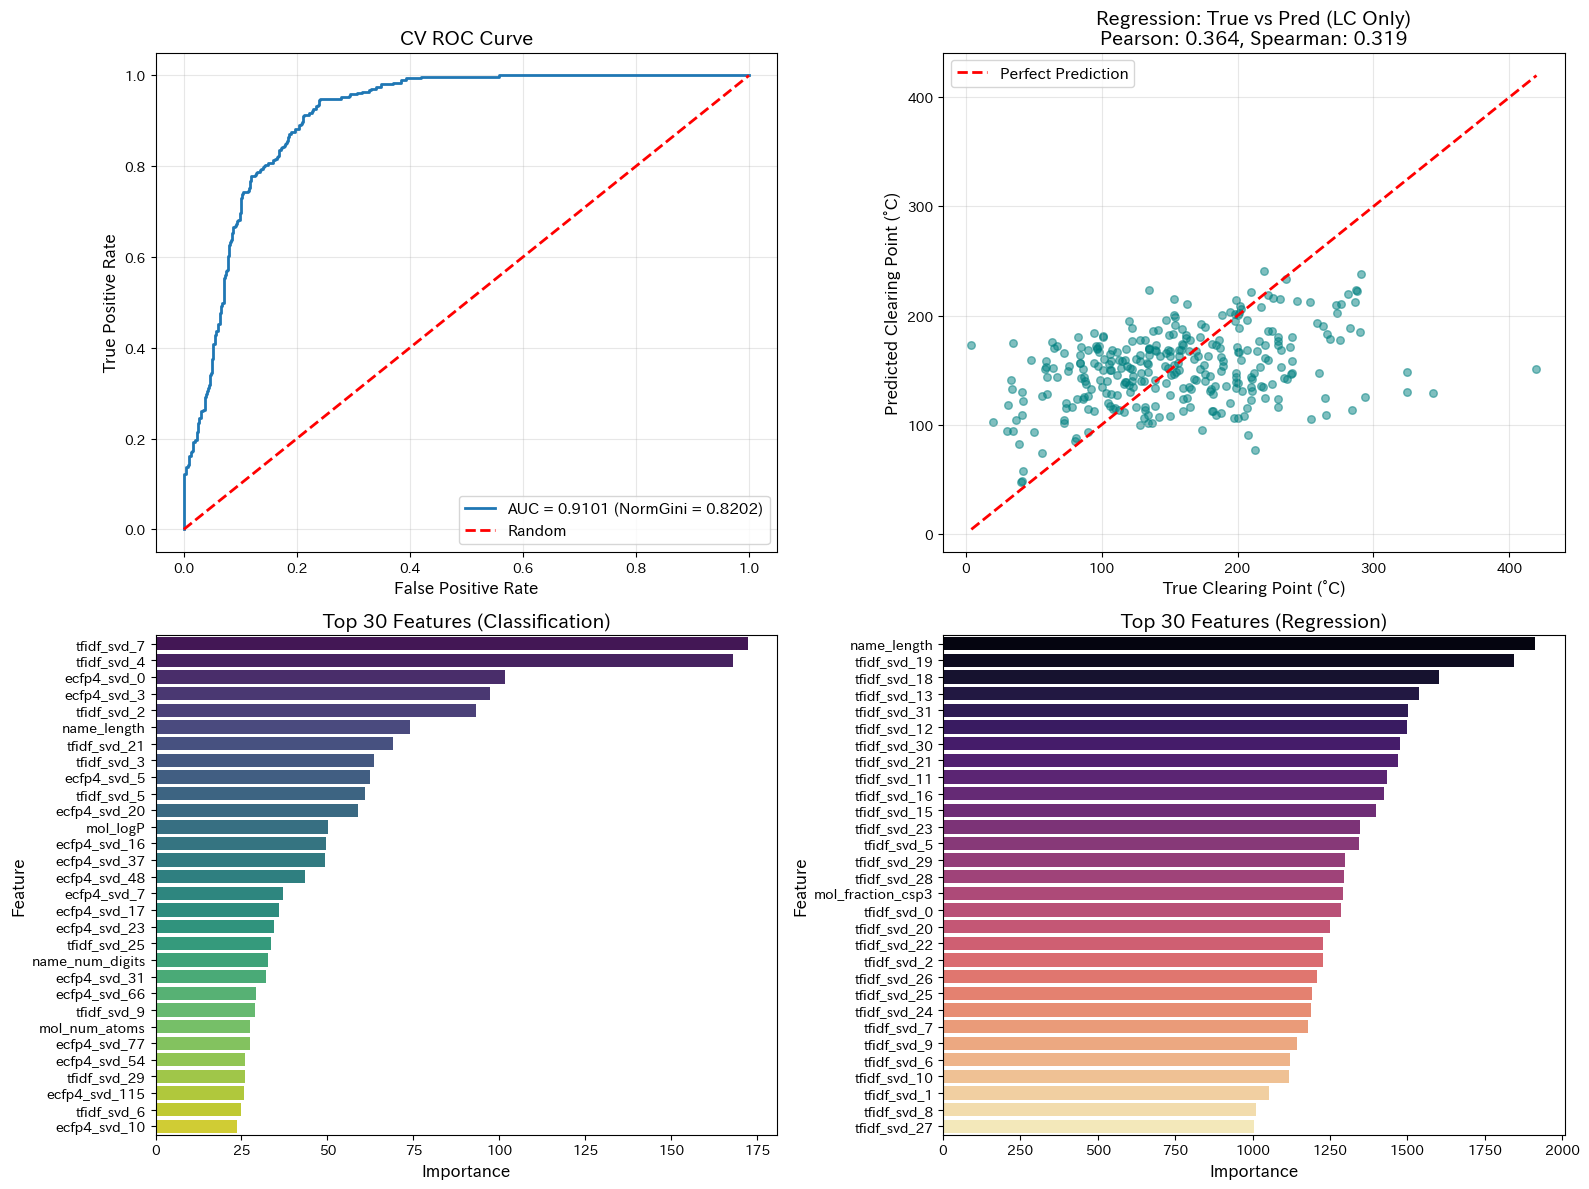

✅ Visualization saved: cv_results.png


In [13]:
# ==============================================
# 📊 可視化 (Feature Names修正版)
# ==============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr, tpr, thresholds = roc_curve(y_cls, oof_prob)
auc_score = roc_auc_score(y_cls, oof_prob)
norm_gini_all = 2 * auc_score - 1

axes[0, 0].plot(fpr, tpr, label=f'AUC = {auc_score:.4f} (NormGini = {norm_gini_all:.4f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'r--', label='Random', linewidth=2)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('CV ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Regression Scatter Plot (LC Only)
lc_mask = (y_cls == 1)
y_true_lc = y_reg[lc_mask]
y_pred_lc = oof_temp[lc_mask]

p_corr, _ = pearsonr(y_true_lc, y_pred_lc)
s_corr, _ = spearmanr(y_true_lc, y_pred_lc)

axes[0, 1].scatter(y_true_lc, y_pred_lc, alpha=0.5, c='teal', s=30)
axes[0, 1].plot([y_true_lc.min(), y_true_lc.max()], 
                [y_true_lc.min(), y_true_lc.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_title(f'Regression: True vs Pred (LC Only)\nPearson: {p_corr:.3f}, Spearman: {s_corr:.3f}', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('True Clearing Point (°C)', fontsize=12)
axes[0, 1].set_ylabel('Predicted Clearing Point (°C)', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance (Classification) - 修正版
df_imp_clf = pd.DataFrame({
    'feature': feature_names,  # ここを修正
    'importance': feature_importance_clf
})
df_imp_clf = df_imp_clf.sort_values('importance', ascending=False).head(config.viz.top_n_features)

sns.barplot(x='importance', y='feature', data=df_imp_clf, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title(f'Top {config.viz.top_n_features} Features (Classification)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_ylabel('Feature', fontsize=12)

# 4. Feature Importance (Regression) - 修正版
df_imp_reg = pd.DataFrame({
    'feature': feature_names,  # ここを修正
    'importance': feature_importance_reg
})
df_imp_reg = df_imp_reg.sort_values('importance', ascending=False).head(config.viz.top_n_features)

sns.barplot(x='importance', y='feature', data=df_imp_reg, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title(f'Top {config.viz.top_n_features} Features (Regression)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Importance', fontsize=12)
axes[1, 1].set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.savefig('cv_results.png', dpi=150, bbox_inches='tight')
plt.show()

# W&B に画像をログ
if config.wandb.use_wandb:
    wandb.log({"cv_visualization": wandb.Image('cv_results.png')})
    
    # Feature Importance テーブルもログ
    wandb.log({
        "feature_importance/classification": wandb.Table(dataframe=df_imp_clf),
        "feature_importance/regression": wandb.Table(dataframe=df_imp_reg)
    })

print("✅ Visualization saved: cv_results.png")

---
# 5️⃣ 全データで再学習 (Full Training)

In [14]:
# ==============================================
# 🚀 全データで再学習 (Full Training)
# ==============================================
sep("🚀 Starting Full Training for Submission...")
# フルデータ学習用のパラメータ（CVの平均最適イテレーション数を使用）
params_clf_full = config.model.classification.copy()
params_reg_full = config.model.regression.copy()

# early_stopping_rounds を削除し、num_boost_round を最適値に設定
params_clf_full.pop('early_stopping_rounds', None)
params_reg_full.pop('early_stopping_rounds', None)

# CVで得られた平均最適イテレーション数を使用（安全マージンとして+10%）
params_clf_full['n_estimators'] = int(avg_best_iter_clf * 1.1)
if best_iterations_reg:
    params_reg_full['n_estimators'] = int(avg_best_iter_reg * 1.1)

print(f"📍 Using optimized iterations from CV:")
print(f"   Classification: {params_clf_full['n_estimators']} iterations (CV avg: {avg_best_iter_clf})")
if best_iterations_reg:
    print(f"   Regression: {params_reg_full['n_estimators']} iterations (CV avg: {avg_best_iter_reg})")
print()

# 1. Classification Model (全データ)
print("🎯 Training Full Classification Model...")
clf_full = lgb.LGBMClassifier(**params_clf_full)
clf_full.fit(X, y_cls)
pred_prob_test = clf_full.predict_proba(X_test)[:, 1]
print(f"   ✅ Classification Model Trained ({clf_full.n_estimators} iterations)")

# 2. Regression Model (LC samples only)
mask_lc_all = (y_cls == 1)
print(f"📊 Training Full Regression Model ({mask_lc_all.sum()} LC samples)...")
reg_full = lgb.LGBMRegressor(**params_reg_full)
reg_full.fit(X[mask_lc_all], y_reg[mask_lc_all])
pred_temp_test = reg_full.predict(X_test)
print(f"   ✅ Regression Model Trained ({reg_full.n_estimators} iterations)")

print("\n✅ Full Training Completed!")

# Test データの予測値統計
print(f"\n📊 Test Predictions:")
print(f"   Classification (prob): mean={pred_prob_test.mean():.4f}, std={pred_prob_test.std():.4f}")
print(f"   Regression (temp): mean={pred_temp_test.mean():.2f}, std={pred_temp_test.std():.2f}")

# W&B にモデルを保存
if config.wandb.use_wandb:
    # モデルファイルを保存
    joblib.dump(clf_full, 'clf_full.pkl')
    joblib.dump(reg_full, 'reg_full.pkl')
    
    # W&B にアップロード
    wandb.save('clf_full.pkl')
    wandb.save('reg_full.pkl')
    
    print("✅ Models saved to W&B")

✨ 🚀 Starting Full Training for Submission...
📍 Using optimized iterations from CV:
   Classification: 1081 iterations (CV avg: 983)
   Regression: 5500 iterations (CV avg: 5000)

🎯 Training Full Classification Model...
   ✅ Classification Model Trained (1081 iterations)
📊 Training Full Regression Model (311 LC samples)...
   ✅ Regression Model Trained (5500 iterations)

✅ Full Training Completed!

📊 Test Predictions:
   Classification (prob): mean=0.1986, std=0.3205
   Regression (temp): mean=142.57, std=26.62
✅ Models saved to W&B


In [15]:
# ==============================================
# 📝 提出ファイル作成
# ==============================================
sub = pd.DataFrame({'row_id': df_test_processed['row_id'].to_pandas()})
sub['prediction'] = [f"[{p:.4f}, {t:.2f}]" for p, t in zip(pred_prob_test, pred_temp_test)]

submission_file = f'submission_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
sub.to_csv(submission_file, index=False)

print(f"\n✅ Submission file saved: {submission_file}")
print(f"📊 Submission shape: {sub.shape}")

# W&B に提出ファイルも保存
if config.wandb.use_wandb:
    wandb.save(submission_file)
    wandb.finish()
    print("✅ W&B run finished")

# Preview
print("\n📋 Submission Preview:")
display(sub.head(10))

wandb: updating run metadata



✅ Submission file saved: submission_20251228_044959.csv
📊 Submission shape: (1127, 2)


wandb: uploading summary, console lines 100-110
wandb: 
wandb: Run history:
wandb:      cv/avg_best_iter_clf ▁
wandb:      cv/avg_best_iter_reg ▁
wandb: cv/overall_decoupled_rank ▁▁
wandb:      cv/overall_norm_gini ▁▁
wandb:       cv/overall_spearman ▁▁
wandb:      cv/std_best_iter_clf ▁
wandb:      cv/std_best_iter_reg ▁
wandb:                fold_1/auc ▁
wandb:     fold_1/decoupled_rank ▁
wandb:          fold_1/norm_gini ▁
wandb:                       +22 ...
wandb: 
wandb: Run summary:
wandb:      cv/avg_best_iter_clf 983
wandb:      cv/avg_best_iter_reg 5000
wandb: cv/overall_decoupled_rank 0.56976
wandb:      cv/overall_norm_gini 0.82021
wandb:       cv/overall_spearman 0.31932
wandb:      cv/std_best_iter_clf 264
wandb:      cv/std_best_iter_reg 0
wandb:                fold_1/auc 0.8415
wandb:     fold_1/decoupled_rank 0.57736
wandb:          fold_1/norm_gini 0.683
wandb:                       +22 ...
wandb: 
wandb: 🚀 View run cv-training-044841 at: https://toyota.wandb.io/hidebu

✅ W&B run finished

📋 Submission Preview:


,row_id,prediction
0,1020,"[0.0858, 159.56]"
1,1021,"[0.0009, 149.32]"
2,1022,"[0.5860, 98.32]"
3,1023,"[0.1423, 182.26]"
4,1024,"[0.1368, 150.60]"
5,1025,"[0.7718, 84.25]"
6,1026,"[0.1110, 206.02]"
7,1027,"[0.0000, 96.89]"
8,1028,"[0.0060, 156.97]"
9,1029,"[0.0478, 117.91]"
